In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
# Define the file path
file_path = "/content/drive/MyDrive/Reviews.csv"

df = pd.read_csv(file_path)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [5]:
# Drop specified columns
columns_to_drop = ['ProductId', 'Id', 'ProfileName', 'UserId', 'HelpfulnessDenominator', 'HelpfulnessNumerator', 'Time']
df.drop(columns=columns_to_drop, inplace=True)


In [6]:
# Verify the columns are dropped
df.head()

,Score,Summary,Text
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [8]:
# Combine 'summary' and 'text' into a single feature, ensuring all text is properly handled
df['Summary'] = df['Summary'].fillna('').astype(str)
df['Text'] = df['Text'].fillna('').astype(str)
df['Combined_text'] = df['Summary'] + " " + df['Text']

In [9]:
# Preprocess the text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['Combined_text'])
sequences = tokenizer.texts_to_sequences(df['Combined_text'])
word_index = tokenizer.word_index

In [10]:
# Pad sequences to ensure uniform input size
max_length = 300
data = pad_sequences(sequences, maxlen=max_length)
data.shape

(568454, 300)

In [11]:
y_dict = {1:0, 2:0, 3:1, 4:1, 5:1}
y = df['Score'].map(y_dict)
y

0         1
1         0
2         1
3         0
4         1
         ..
568449    1
568450    0
568451    1
568452    1
568453    1
Name: Score, Length: 568454, dtype: int64

In [12]:
ros = RandomOverSampler(random_state=42)
data_resampled, labels_resampled = ros.fit_resample(data, y)

label_counts = Counter(labels_resampled)
print(label_counts)


Counter({1: 486417, 0: 486417})


In [13]:
from tensorflow.keras.utils import to_categorical
# Encode labels (after oversampling)
label_encoder = LabelEncoder()
labels_resampled = label_encoder.fit_transform(labels_resampled)
labels_resampled = to_categorical(labels_resampled, num_classes=2)

In [14]:
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(data_resampled, labels_resampled, test_size=0.2, random_state=42)

In [15]:
print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

x_train shape: (778267, 300)
x_val shape: (194567, 300)
y_train shape: (778267, 2)
y_val shape: (194567, 2)


In [16]:
# --- 5. Build the CNN Model ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_length))

# Convolutional layers
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 296, 128)          82048     
                                                                 
 max_pooling1d (MaxPooling1  (None, 148, 128)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 146, 64)           24640     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 73, 64)            0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 4672)              0

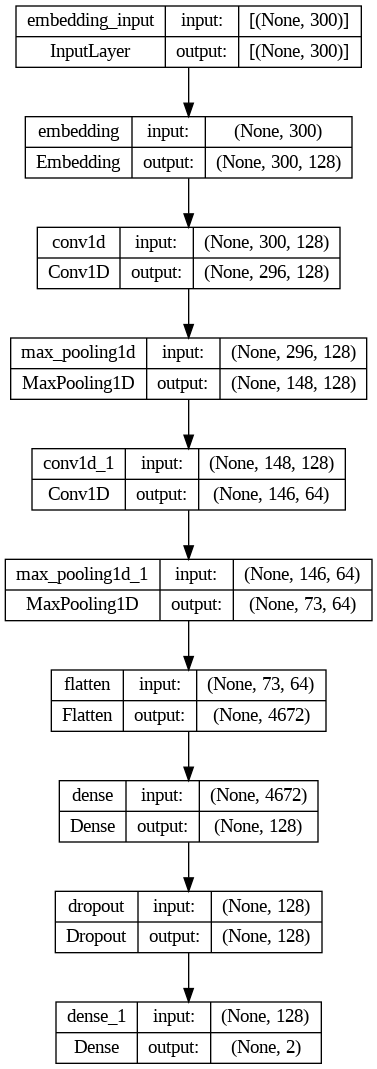

In [17]:
from tensorflow.keras.utils import plot_model

# Assuming your model is already created and named `model`

plot_model(model, to_file="Architecture of Amazon CNN  2 scores.png", show_shapes=True)  # Adjust filename as needed

In [ ]:
import time
# Start time measurement
start_time = time.time()

# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_val, y_val))

# End time measurement
end_time = time.time()

# Calculate total time
total_time = end_time - start_time
print(f"Total training time: {total_time:.4f} seconds")

Epoch 1/5
24321/24321 [==============================] - 232s 9ms/step - loss: 0.1524 - accuracy: 0.9449 - val_loss: 0.1036 - val_accuracy: 0.9661
Epoch 2/5
24321/24321 [==============================] - 175s 7ms/step - loss: 0.0792 - accuracy: 0.9746 - val_loss: 0.0958 - val_accuracy: 0.9690
Epoch 3/5
24321/24321 [==============================] - 168s 7ms/step - loss: 0.0530 - accuracy: 0.9838 - val_loss: 0.0836 - val_accuracy: 0.9777
Epoch 4/5
24321/24321 [==============================] - 170s 7ms/step - loss: 0.0394 - accuracy: 0.9882 - val_loss: 0.0694 - val_accuracy: 0.9821
Epoch 5/5
24321/24321 [==============================] - 164s 7ms/step - loss: 0.0315 - accuracy: 0.9909 - val_loss: 0.0776 - val_accuracy: 0.9819
Total training time: 910.0702 seconds


In [ ]:
# Predict on the validation set
y_val_pred = model.predict(x_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_val, axis=1)

6081/6081 [==============================] - 15s 2ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
# Calculate metrics
accuracy = accuracy_score(y_val_true, y_val_pred_classes)
precision = precision_score(y_val_true, y_val_pred_classes, average='weighted')
recall = recall_score(y_val_true, y_val_pred_classes, average='weighted')
f1 = f1_score(y_val_true, y_val_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_val_true, y_val_pred_classes)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

print("\nClassification Report:\n", classification_report(y_val_true, y_val_pred_classes))



Accuracy: 0.9819445229663818
Precision: 0.9822866701960462
Recall: 0.9819445229663818
F1 Score: 0.9819413415349113

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     97275
           1       1.00      0.97      0.98     97292

    accuracy                           0.98    194567
   macro avg       0.98      0.98      0.98    194567
weighted avg       0.98      0.98      0.98    194567



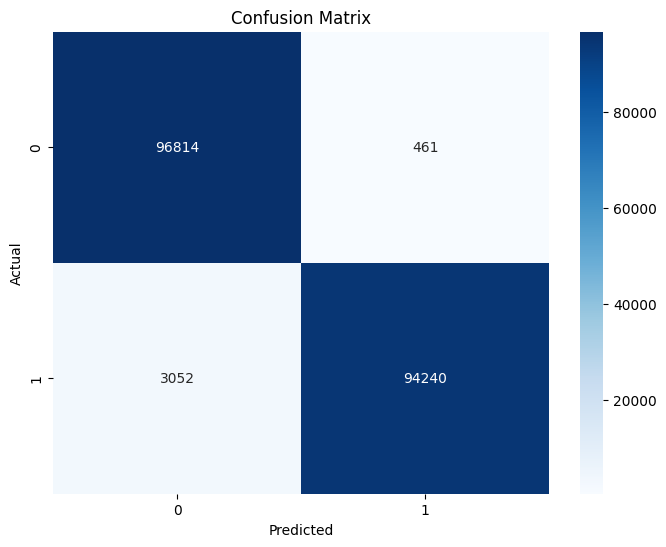

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()